In [1]:
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
home_dir = os.getenv("HOME")
raw_data = pd.read_csv(home_dir + '/Desktop/DataPacket/data.csv')

In [3]:
raw_data.head()

,laser0,laser1,laser2,laser3,laser4,laser5,laser6,laser7,laser8,laser9,...,laser352,laser353,laser354,laser355,laser356,laser357,laser358,laser359,speed,steering_angle
0,0.228333,0.227496,0.234184,0.253645,0.238905,0.224904,0.219742,0.225911,0.236172,0.221523,...,0.224054,0.248701,0.230076,0.243954,0.245454,0.225626,0.246615,0.244948,0.244948,0.585937
1,0.228333,0.227496,0.234184,0.253645,0.238905,0.224904,0.219742,0.225911,0.236172,0.221523,...,0.224054,0.248701,0.230076,0.243954,0.245454,0.225626,0.246615,0.244948,0.244948,0.585937
2,0.231983,0.244641,0.244981,0.224927,0.235483,0.222170,0.225249,0.235063,0.217606,0.233925,...,0.233786,0.242592,0.240255,0.225518,0.239098,0.246102,0.236991,0.250182,0.250182,0.600930
3,0.237585,0.226259,0.225327,0.241955,0.234837,0.225581,0.239836,0.223831,0.220821,0.220462,...,0.239585,0.228006,0.226670,0.248297,0.234633,0.228943,0.237144,0.233428,0.233428,0.600727
4,0.222417,0.230397,0.242593,0.251118,0.238735,0.237531,0.239533,0.239257,0.240184,0.254118,...,0.244356,0.262002,0.238537,0.229623,0.220751,0.249123,0.232163,0.234454,0.234454,0.591369


In [4]:
laser_data = raw_data.drop(["steering_angle", "speed"], axis=1)

laser_data = laser_data.values

maximum_laser_range = 12.0

for i in range(len(laser_data)):
    for j in range(len(laser_data[i])):
        if np.isinf(laser_data[i][j]):
            laser_data[i][j] = maximum_laser_range
            
laser_data = laser_data / 12

from sklearn.model_selection import train_test_split

X_laser_train, X_laser_validation = train_test_split(laser_data, test_size=0.2)

In [5]:
speed = raw_data["speed"].values
steering_angle = raw_data["steering_angle"].values

output = np.dstack((steering_angle, speed))[0]

In [6]:
output[:5]

array([[0.58593744, 0.24494842],
       [0.58593744, 0.24494842],
       [0.60093027, 0.2501817 ],
       [0.6007266 , 0.23342802],
       [0.59136927, 0.23445369]])

In [7]:
img_input = []
h = 240
w = 320
c = 3
img_num = len(raw_data) + 1  # Because csv lenght start with 0

for i in range(1, img_num):
    img = cv2.imread(home_dir + "/Desktop/DataPacket/Images/"+str(i)+".jpg", c)
    img = cv2.resize(img, (w, h))
    
    img_input.append(img)

In [8]:
img_input = np.asarray(img_input).astype(np.float32) / 255.0

In [9]:
img_input.shape

(40, 240, 320, 3)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(img_input, output, test_size=0.2, random_state=22)

del img_input
del steering_angle
del output
del speed

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Concatenate, Input
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers.core import Activation

Using TensorFlow backend.


In [12]:
X_train.shape

(32, 240, 320, 3)

In [13]:
y_train.shape

(32, 2)

In [14]:
laser_data.shape[1]

360

In [15]:
model = Sequential()

model.add(Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 24, kernel_size = (7,7),padding = 'same',activation ='relu'))
model.add(Flatten())

image_input = Input(shape=(h, w, c))
flatten_image_outputs = model(image_input)

laser_input = Input(shape = (laser_data.shape[1],))
concatenatedFeatures = Concatenate(axis = 1)([laser_input, flatten_image_outputs])

dense = Dense(128, activation = "relu")(concatenatedFeatures)
dense = Dense(64, activation = "relu")(dense)
dense = Dense(16, activation = "relu")(dense)
main_output = Dense(2, activation = "softmax")(dense)

drive_model = Model(inputs=[image_input,laser_input], outputs=main_output)

drive_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
hs = drive_model.fit([X_train, X_laser_train], y_train, validation_data=([X_validation, X_laser_validation], y_validation), batch_size=64, epochs=5)

Instructions for updating:
Use tf.cast instead.
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 7s 211ms/step - loss: 0.0393 - acc: 0.0000e+00 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 5s 159ms/step - loss: 0.0422 - acc: 0.0000e+00 - val_loss: 0.0262 - val_acc: 1.0000
Epoch 3/5
32/32 [==============================] - 5s 169ms/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 1.0000
Epoch 4/5
32/32 [==============================] - 5s 165ms/step - loss: 0.0183 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 5/5
32/32 [==============================] - 6s 174ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000


In [17]:
import plotly
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

def trainingResultsGraph(model, modelCode):
    trace0 = go.Scatter(
        x = model.epoch,
        y = model.history['loss'],
        mode = 'lines',
        name = 'loss',
        line=dict(color='aquamarine')
    )

    trace1 = go.Scatter(
        x = model.epoch,
        y = model.history['val_loss'],
        mode = 'lines',
        name = 'val_loss',
        line=dict(color='darkred', dash='dash')
    )

    trace2 = go.Scatter(
        x = model.epoch,
        y = model.history['acc'],
        mode = 'lines',
        name = 'acc',
        line=dict(color='violet')
    )

    trace3 = go.Scatter(
        x = model.epoch,
        y = model.history['val_acc'],
        mode = 'lines',
        name = 'val_acc',
        line=dict(color='aqua', dash='dash')
    )

    updatemenus = list([
        dict(type="buttons",
             active=-1,
             buttons=list([
                dict(label = 'Acc Graph',
                     method = 'update',
                     args = [{'visible': [False, False, True, True]},
                             {'title': 'Trained Model'+modelCode+' training and validation accuracy'}]),
                dict(label = 'Loss Graph',
                     method = 'update',
                     args = [{'visible': [True, True, False, False]},
                             {'title': 'Trained Model'+modelCode+' training and validation loss'}]),
                dict(label = 'Both',
                     method = 'update',
                     args = [{'visible': [True, True, True, True]},
                             {'title': 'Trained Model'+modelCode+' training and validation values'}])
            ]),
        )
    ])

    data = [trace0, trace1, trace2, trace3]
    layout = dict(title='Trained Model'+modelCode+' training and validation values',
                  xaxis = dict(title = 'Epochs'),
                  updatemenus=updatemenus)

    fig = dict(data=data, layout=layout)

    iplot(fig, filename='lossGraph')
    
trainingResultsGraph(hs, "1")

In [33]:
try:
    __import__("rospkg")
    __import__("rospy")

    rospack = rospkg.RosPack()
    package_path = rospack.get_path('angelshark_deeplearning')
    
except ImportError:
    package_path = home_dir + "/Desktop"
    
    import os
    if not os.path.exists(package_path + "/model"):
        os.makedirs(package_path + "/model")
    
    print("Model saved to Desktop/model dir!!!")
    print("Please move them to deeplearning package model directory to angelshark_deeplearning/model")

Model saved to Desktop/model dir!!!
Please move them to deeplearning package model directory angelshark_deeplearning/model


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


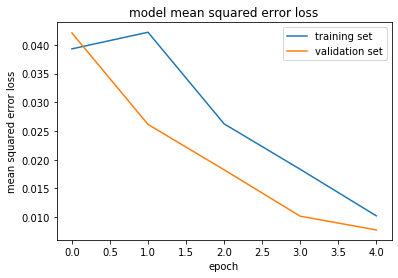

In [28]:
import json
import matplotlib.pylab as plt
import random
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

# Save model weights and json.
model.save_weights(package_path + '/model/model.h5')
model_json = model.to_json()
with open(package_path + '/model/model.json', 'w') as outfile:
    json.dump(model_json, outfile)

# Train and validation loss chart
print(hs.history.keys())

plt.plot(hs.history['loss'])
plt.plot(hs.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
